![image.png](https://i.imgur.com/a3uAqnb.png)

# 🎯 Introduction

In this lab, we explore how **attention mechanisms** can be used to improve performance and interpretability in natural language processing (NLP), specifically for **sentiment analysis** on the IMDb movie review dataset.

You'll build a lightweight yet powerful neural model that combines:

- 🔤 **Tokenization and text preprocessing**
- 🧱 **Word embeddings** and a **GRU encoder**
- 🎯 **Dot-product attention** using PyTorch's `MultiheadAttention`
- 📊 **Visual explanations** that highlight which words influenced the model's decision

By the end of this lab, you will:

✅ Train a binary sentiment classifier using attention  
✅ Interpret the model’s predictions using attention heatmaps and bar plots  
✅ Interactively analyze your own sentences with real-time visualization  


## 📦 Cell 1: Setup and Environment Initialization
- `datasets` and `tqdm` are installed (PyTorch is already available in Colab).
- Loads essential libraries: PyTorch, data processing, visualization, and text utilities.
- Sets random seeds for reproducibility (`torch`, `random`, `numpy`).
- Determines the computation device: **GPU if available**, otherwise CPU.


In [14]:
# Install lightweight deps (datasets) — PyTorch is pre‑installed in Colab
!pip -q install --upgrade datasets tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import html, re, string, random
from collections import Counter
import matplotlib
from IPython.display import HTML, display
import html
SEED = 42
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)


Running on: cuda


## 📁 Cell 2: Load IMDb Dataset
### This cell loads the IMDb sentiment classification dataset using Hugging Face's `datasets` library.

* Retrieves the `train` and `test` splits.
* Prints a sample review and its corresponding binary label (`0 = negative`, `1 = positive`).


In [15]:
imdb = load_dataset("imdb")
train_raw = imdb["train"]
test_raw  = imdb["test"]

print("Sample review:", train_raw[0]["text"][:300], "…")
print("Label:", train_raw[0]["label"])

Sample review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h …
Label: 0


## 🧹 Cell 3: Text Cleaning & Tokenization

### Defines a custom tokenization function for cleaning text:

- Removes HTML tags, URLs, and punctuation.
- Converts to lowercase and splits into tokens.
- Optionally removes **stop words** like "the", "is", "we", etc.
- Defines `<PAD>` and `<UNK>` tokens for padding and unknown words.



In [16]:
STOP_WORDS = {
    "the","a","an","and","or","but","if","in","on","at","to","of",
    "for","with","by","as","is","was","are","were","be","been","being",
    "it","its","this","that","these","those","so","very","i","me","my",
    "you","your","he","she","they","them","we","us"
}

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

punct_pat     = f"[{re.escape(string.punctuation)}]"
url_pat       = r"https?://\S+|www\.\S+"
html_tag_pat  = r"<[^>]+>"

def basic_tokenize(text: str, keep_stops: bool = False):
    """Simple cleaner + optional stop‑word removal."""
    text = html.unescape(text)
    text = re.sub(html_tag_pat, " ", text)
    text = re.sub(url_pat, " ", text)
    text = text.lower()
    text = re.sub(punct_pat, " ", text)

    tokens = text.split()
    if not keep_stops:
        tokens = [t for t in tokens if t not in STOP_WORDS]
    return tokens


## 🔡 Cell 4: Vocabulary Building and Encoding
### This cell builds a vocabulary from training data and defines an encoder:

- Counts word frequencies using `Counter`.
- Assigns unique indices to words, starting from `2` (reserving `0` for `<PAD>` and `1` for `<UNK>`).
- Defines `encode()` to:
  - Convert text into token IDs based on the vocabulary.
  - Pad sequences to a fixed `max_len` (default = 200).


In [17]:
vocab_counter = Counter()
for ex in train_raw["text"]:
    vocab_counter.update(basic_tokenize(ex))

vocab = {w: i + 2 for i, (w, _) in enumerate(vocab_counter.most_common())}
vocab[PAD_TOKEN] = 0
vocab[UNK_TOKEN] = 1

# ummm what could be done here ?
def encode(text: str, max_len: int = 200):
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in basic_tokenize(text)[:max_len]]
    ids += [vocab[PAD_TOKEN]] * (max_len - len(ids))
    return ids

## 📦 Cell 5: PyTorch Dataset & DataLoader
### Creates a custom dataset and dataloaders:

- `IMDbAttnDataset`:
  - Encodes each review using the vocabulary.
  - Returns `(input_tensor, label_tensor)` for each example.
- `train_dl` and `test_dl` are created using `DataLoader`, with batching and shuffling for training.
- Prints vocabulary size and token IDs for `<PAD>` and `<UNK>`.


In [18]:
class IMDbAttnDataset(Dataset):
    def __init__(self, hf_split):
        self.texts  = hf_split["text"]
        self.labels = hf_split["label"]

    def __len__(self):
      return len(self.texts)

    def __getitem__(self, idx):
        return (
            torch.tensor(encode(self.texts[idx]), dtype=torch.long),
            torch.tensor(self.labels[idx])
            )

BATCH = 64
train_ds, test_ds = IMDbAttnDataset(train_raw), IMDbAttnDataset(test_raw)
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=BATCH)

print(f"✔️  DataLoaders ready  —  vocab size: {len(vocab):,}  "
      f"(PAD={vocab[PAD_TOKEN]}, UNK={vocab[UNK_TOKEN]})")


✔️  DataLoaders ready  —  vocab size: 75,244  (PAD=0, UNK=1)


## 🧠 Cell 6: Attention-Based Sentiment Classifier
### Defines the `UniDotProdAttnClassifier` PyTorch model:

- Uses:
  - Embedding layer (`nn.Embedding`) to map tokens to vectors.
  - GRU (`nn.GRU`) to encode the sequence.
  - Single-head attention via `nn.MultiheadAttention`.
- Attention:
  - The last hidden state of the GRU is used as the **query**.
  - The full GRU output serves as **key** and **value**.
  - Attention output is fed to a linear classifier and passed through `sigmoid` for binary prediction.
- Returns:
  - `prob`: probability of being positive
  - `alpha`: attention weights over the sequence


In [19]:
import torch
import torch.nn as nn

class UniDotProdAttnClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embed   = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.encoder = nn.GRU(embed_dim, hidden_dim, batch_first=True)

        # One‑head dot‑product attention (does the Q/K/V projections for you)
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=1,
            batch_first=True          # keeps (B, T, H) order
        )

        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        mask = (x != 0)                      # (B, T)  — True where not <PAD>
        h_seq, _ = self.encoder(self.embed(x))  # (B, T, H)

        query = h_seq[:, -1:, :]             # (B, 1, H) – last hidden state
        context, attn_w = self.attn(
            query, h_seq, h_seq,             # Q, K, V
            key_padding_mask=~mask           # True where we should ignore
        )
        context = context.squeeze(1)         # (B, H)
        prob    = torch.sigmoid(self.classifier(context).squeeze(1))
        alpha   = attn_w.squeeze(1)          # (B, T)

        return prob, alpha


## 🏋️ Cell 7: Training and Evaluation Loop
### This cell trains the attention model:

- Model, optimizer (`Adam`), and loss function (`BCELoss`) are initialized.
- Runs training for 10 epochs:
  - Calculates predictions, computes loss, backpropagates, and updates parameters.
  - Tracks and prints training loss and accuracy.
- Evaluates accuracy on the test set after each epoch using `model.eval()` and `torch.no_grad()`.


In [20]:
model = UniDotProdAttnClassifier(len(vocab)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.BCELoss()

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for x, y in tqdm(train_dl, desc=f"Epoch {epoch}"):
        x, y = x.to(DEVICE), y.float().to(DEVICE)
        opt.zero_grad()
        preds, _ = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        opt.step()

        running_loss += loss.item() * len(y)
        correct += ((preds > 0.5).long() == y).sum().item()
        total += len(y)

    print(f"Train loss = {running_loss/total:.4f} | accuracy = {correct/total:.4f}")


    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds, _ = model(x)
            correct += ((preds > 0.5).long() == y).sum().item()
            total += len(y)

    print("Test accuracy:", correct / total)


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.5147 | accuracy = 0.7376
Test accuracy: 0.81416


Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.3477 | accuracy = 0.8491
Test accuracy: 0.8414


Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.2762 | accuracy = 0.8855
Test accuracy: 0.85056


Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.2261 | accuracy = 0.9123
Test accuracy: 0.84796


Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.1738 | accuracy = 0.9338
Test accuracy: 0.848


Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.1316 | accuracy = 0.9532
Test accuracy: 0.84844


Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.0900 | accuracy = 0.9690
Test accuracy: 0.84564


Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.0534 | accuracy = 0.9832
Test accuracy: 0.84292


Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.0382 | accuracy = 0.9871
Test accuracy: 0.8414


Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss = 0.0216 | accuracy = 0.9941
Test accuracy: 0.8424


## 🎨 Cell 8: Attention Visualization Function
### Defines a helper function `show_attention_html()`:

- Runs the model on a given input sentence.
- Uses the model's attention weights (`alpha`) to color each token:
  - Light red = low attention, dark red = high attention.
- Displays:
  - The predicted label (`POSITIVE` or `NEGATIVE`)
  - A visually styled HTML string showing each token with its attention score.


In [21]:
def show_attention_html(text):
    """
    Very small helper:
    • runs the model
    • colors each token (light → dark red) by attention weight
    • prints the predicted probability
    """
    model.eval()
    with torch.no_grad():
        ids = encode(text)
        x   = torch.tensor([ids]).to(DEVICE)
        p,  alpha = model(x)

    # tidy up
    w     = alpha.squeeze(0).detach().cpu().numpy()
    toks  = basic_tokenize(text)[:len(w)]
    w_norm = (w - w.min()) / (w.ptp() + 1e-8)      # 0‑1 scale

    spans = []
    for tok, wt in zip(toks, w_norm):
        shade  = int(255 * (1 - wt))               # 1 → white, 0 → red
        color  = f"rgb(255,{shade},{shade})"
        spans.append(f"<span style='background:{color}; padding:2px 4px; "
                     "border-radius:3px; margin:0 1px'>"
                     f"{html.escape(tok)}</span>")

    pred = "POSITIVE" if p.item() > 0.5 else "NEGATIVE"
    header = f"<p><b>Prediction:</b> {pred}  (p={p.item():.2f})</p>"
    display(HTML(header + " ".join(spans)))


## 📊 Cell 9: Visualize Model Attention on a Test Sample
### This cell demonstrates how the model interprets a real IMDb review.

- Uses `show_attention_html()` to visualize which tokens the model focused on.
- The prediction is shown alongside the token-wise attention heatmap.
- Also prints the true label of the review for comparison.


In [22]:
sample_text = test_raw[0]["text"]
show_attention_html(sample_text)
print(f'Label is: {test_raw[0]["label"]}') # 0.01 means 1 % positive → 99 % negative

Label is: 0


## 📉 Cell 10: Visualize Top Attention Tokens as Bar Chart

### Defines `show_attention_vertical()` to create a **bar chart** of the top‑attended tokens.

- Ranks the top `k` words (default 20) by attention score.
- Uses a red colormap to highlight important tokens.
- Plots a horizontal bar chart showing which words influenced the model’s prediction the most.
- Helpful for deeper interpretability beyond just the token-by-token heatmap.


In [23]:
def show_attention_vertical(text, top_k: int = 20, cmap_name: str = "Reds"):
    """
    Horizontal bar chart of the `top_k` most‑attended tokens.
    Tokens are ordered by weight (largest at top).
    """
    model.eval()
    with torch.no_grad():
        ids  = encode(text)
        x    = torch.tensor([ids]).to(DEVICE)
        prob, alpha = model(x)

    # ---- weights & tokens ----
    weights = alpha.squeeze(0).detach().cpu().numpy()
    tokens  = basic_tokenize(text)[:len(weights)]

    idx_top = np.argsort(weights)[-top_k:]          # indices of top‑k
    top_weights = weights[idx_top]
    top_tokens  = [tokens[i] for i in idx_top]

    # sort by weight descending (largest first)
    order = np.argsort(top_weights)[::-1]
    top_weights = top_weights[order]
    top_tokens  = [top_tokens[i] for i in order]

    # ---- colour mapping ----
    cmap   = matplotlib.colormaps.get_cmap(cmap_name)
    norm_w = (top_weights - top_weights.min()) / (top_weights.ptp() + 1e-8)
    colors = cmap(norm_w)

    # ---- plot ----
    plt.figure(figsize=(6, top_k * 0.4))
    plt.barh(range(top_k), top_weights, color=colors,
             edgecolor="black", linewidth=0.5)
    plt.yticks(range(top_k), top_tokens, fontsize=9)
    plt.gca().invert_yaxis()                      # largest at top
    plt.xlabel("Attention weight")
    plt.title(f"{'POS' if prob.item() > 0.5 else 'NEG'} "
              f"(p={prob.item():.2f})  •  Top {top_k} tokens")
    plt.tight_layout()
    plt.show()


## 🧪 Cell 11: Test Vertical Attention Plot
### Applies the `show_attention_vertical()` function to a sample review from the test set.

- Displays the top 25 tokens the model paid attention to.
- Useful for validating and understanding attention behavior on real data.


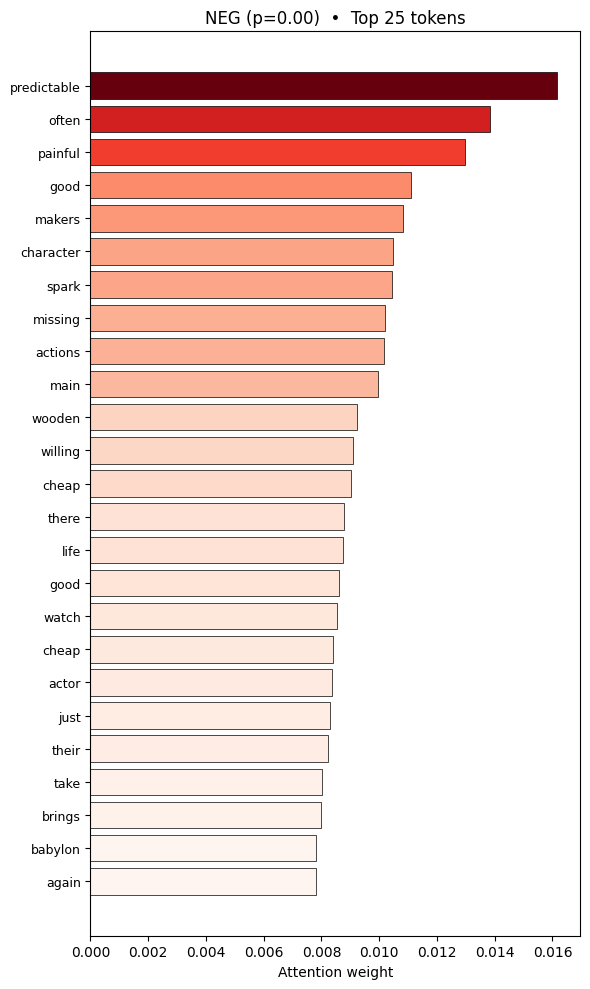

In [24]:
sample = test_raw[0]["text"]
show_attention_vertical(sample, top_k=25)


## 🎤 Cell 12: Interactive Attention Demo
### Lets the user input any sentence interactively:

- The sentence is passed to `show_attention_html()` for prediction and attention visualization.
- Allows you to test how the model reacts to your own custom text in real-time.


In [27]:
text = input("Type a sentence to analyse: ")
show_attention_html(text)


Type a sentence to analyse:  I think The Joker 2019 is a good movie, worth watching.


### Contributed by: Yazan Alshoibi